In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

csv_path = "/Users/edward/Documents/Projects/Projects-2025/cc-fraud-detection/creditcard.csv"
cc = pd.read_csv(csv_path)


## INFORMATION ABOUT DATASET
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [128]:
## Ensure max display for graph visuals
from IPython.display import display, HTML

# Disable scrolling for all output cells
display(HTML("<style>.output_scroll { height: auto; max-height: none; }</style>"))

In [129]:
## Check DataFrame
cc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [130]:
## Check any null values in data
## Conclusion: No null data
cc.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

***Understanding the Class Imbaance:*** In the dataset, the number of Fraud Cases vs Legitimate Cases is highly imbalanced. There are far mroe Legitamite Cases than Fraud Cases, meaning that even if the model just guesses all cases as legitamite, the accuracy rate would still be very high. Below is a graph of Fraud Transactions vs Legitamite Transactions to help understand the discrepency.

Distribution and number of Fraud cases and Non-Fraud Cases
0.00002% of dataset is fraud


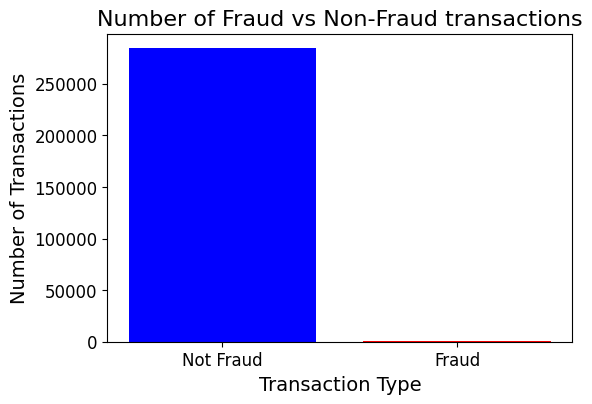

In [136]:
print("Distribution and number of Fraud cases and Non-Fraud Cases")
not_fraud = cc[cc['Class'] == 0] ## 0 in dataset column of class is for not fraud
fraud = cc[cc['Class'] == 1] ## 1 in dataset column of class is for fraud
pct = len(fraud) / (len(fraud) + len(not_fraud) * 100)
print(f"{pct:.5f}% of dataset is fraud")

## Plotting
categories = ['Not Fraud', 'Fraud']
counts = [len(not_fraud), len(fraud)]
plt.figure(figsize=(6, 4)) 
plt.bar(categories, counts, color=['blue', 'red'])

# Adding labels and title
plt.title('Number of Fraud vs Non-Fraud transactions', fontsize=16)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xlabel('Transaction Type', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

***Understanding our Independant Variables***

In order to understand the our independant variables better and to utilize feature selection, we will graph the distribution of the independant variables for fraud transactions and legitimate transactions

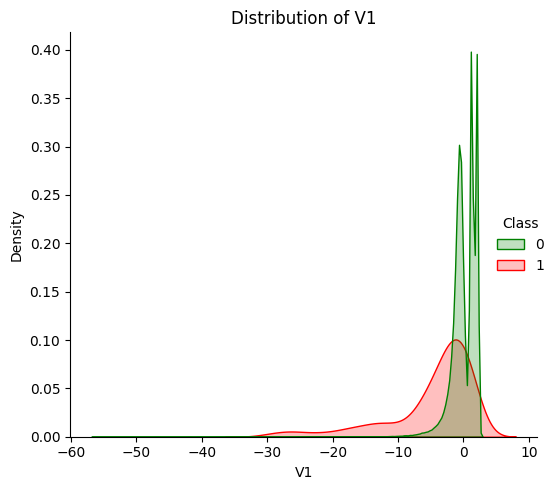

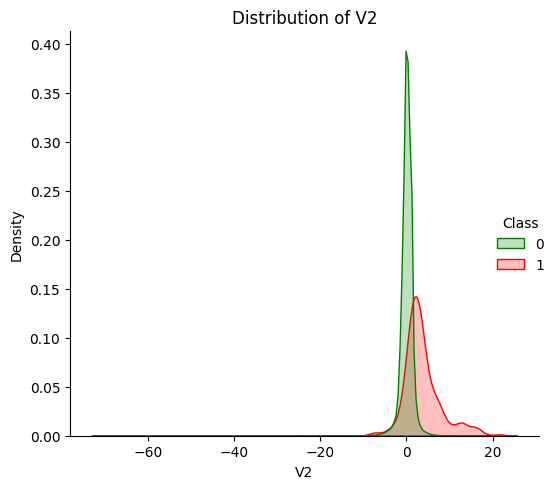

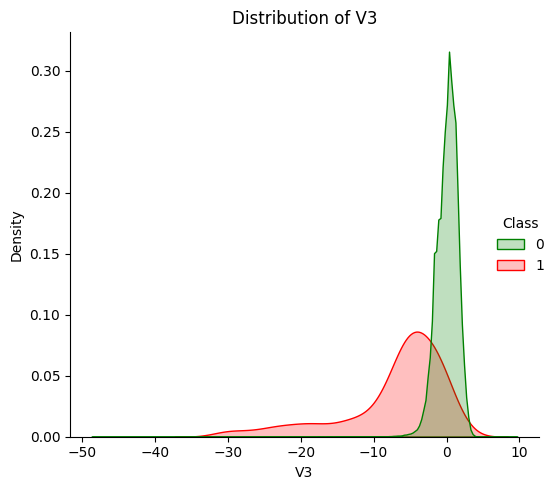

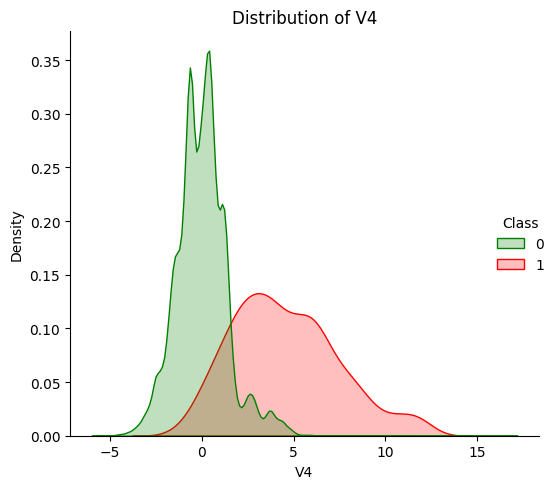

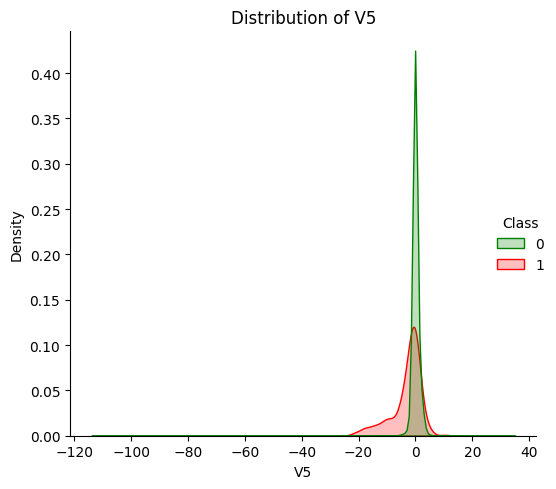

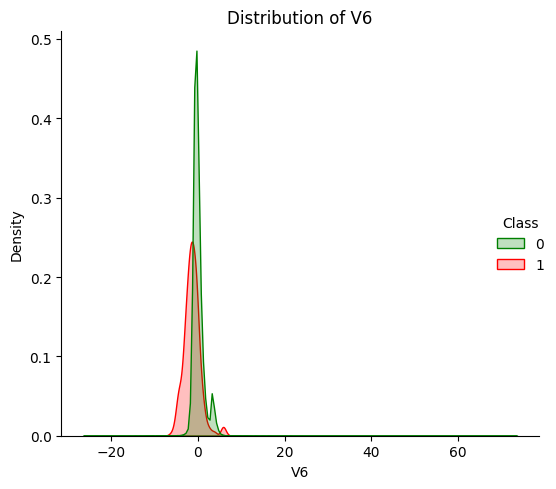

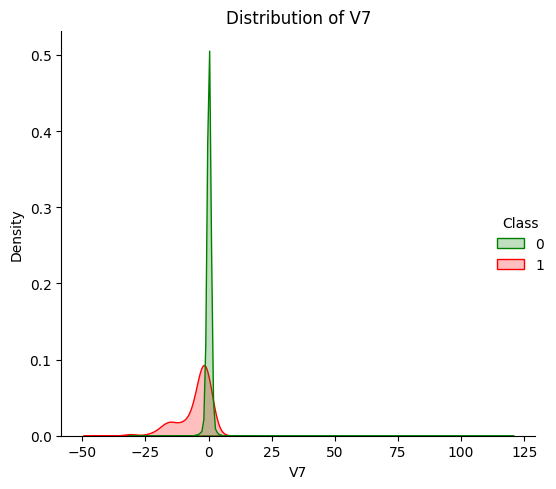

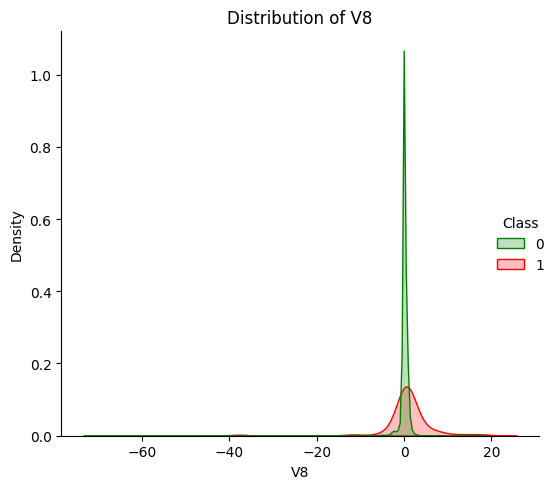

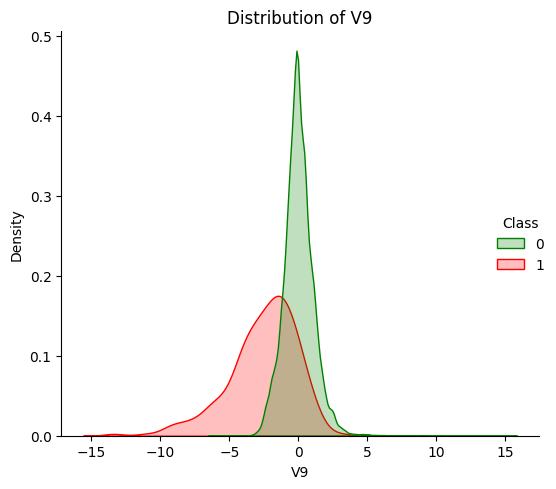

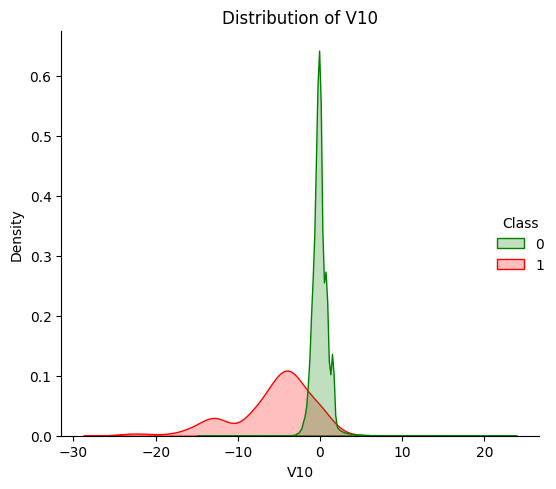

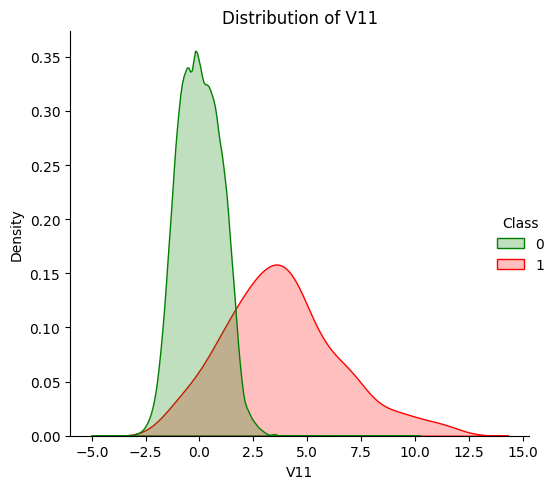

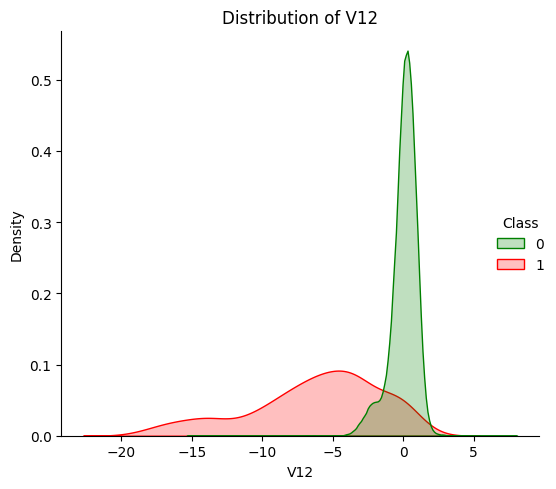

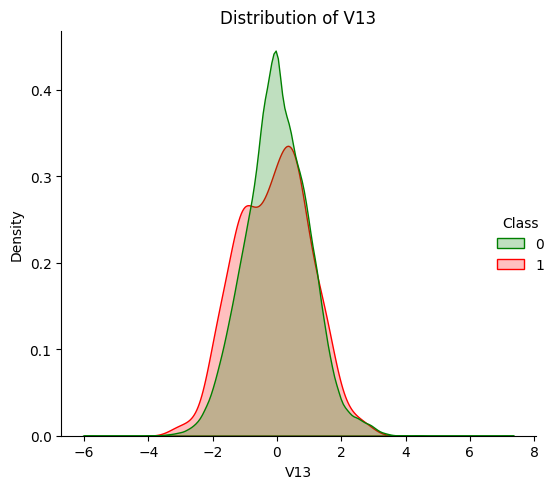

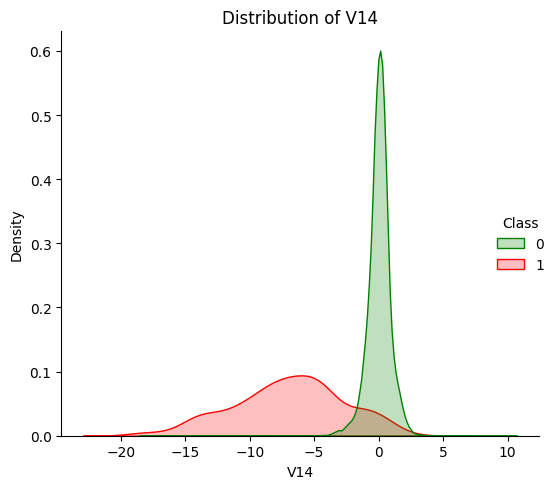

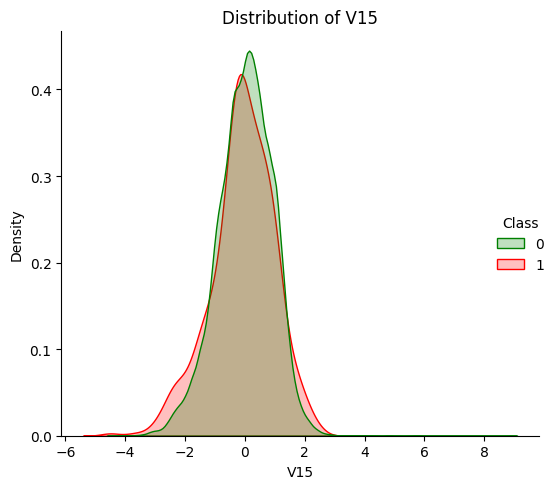

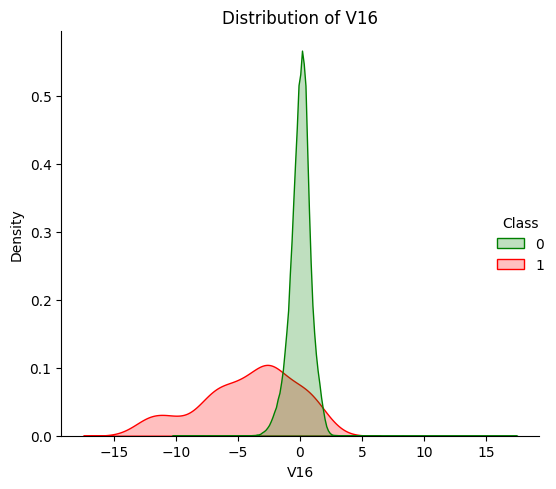

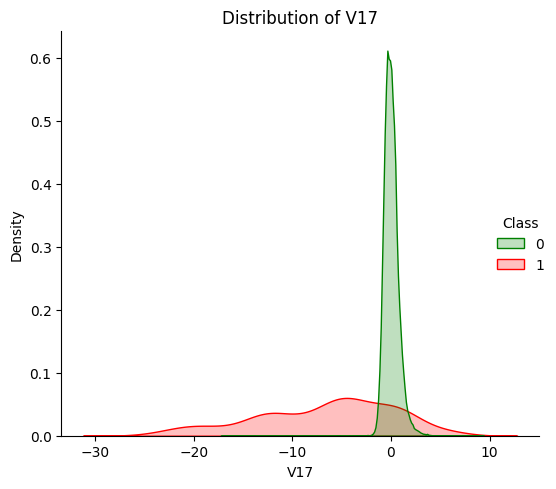

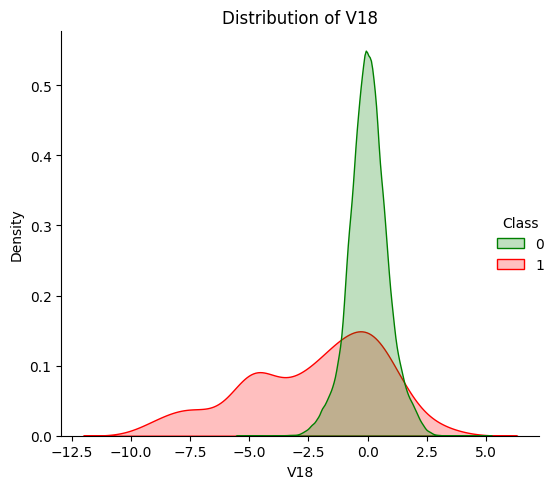

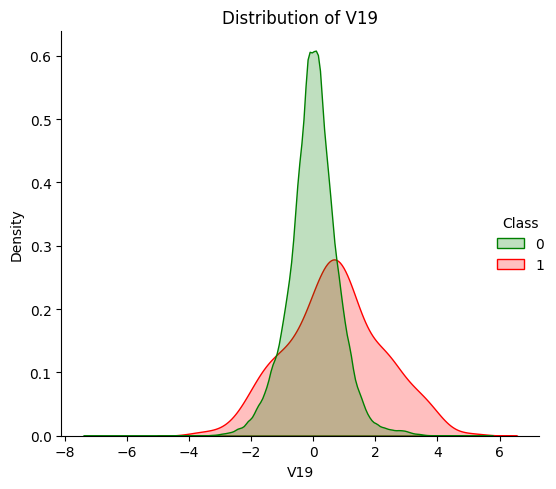

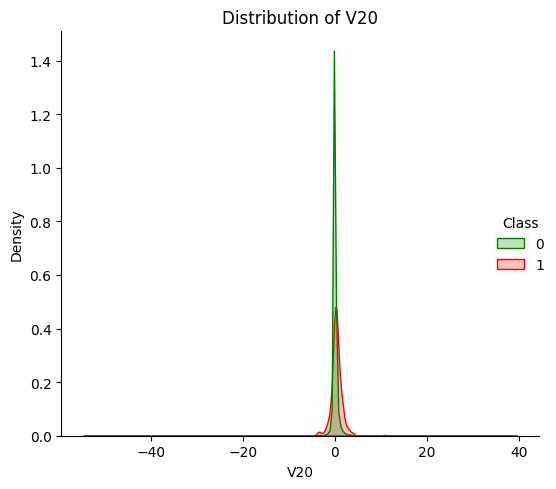

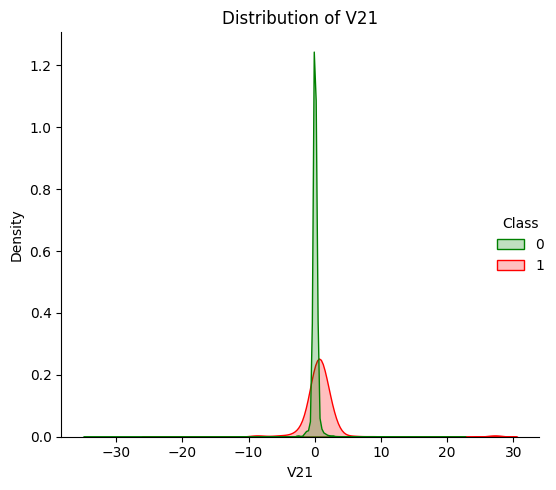

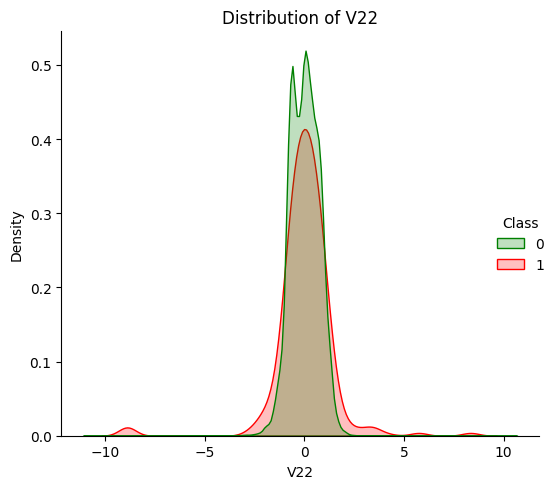

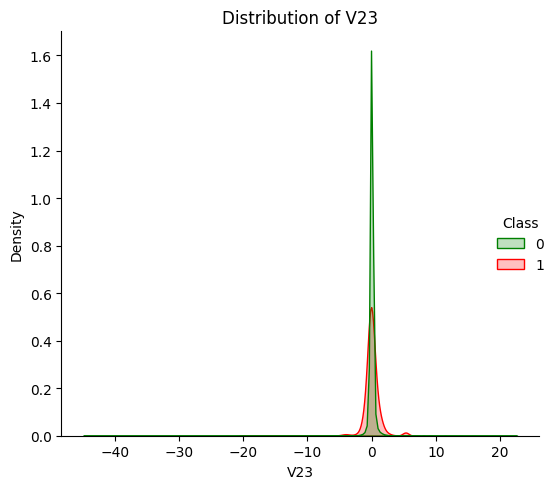

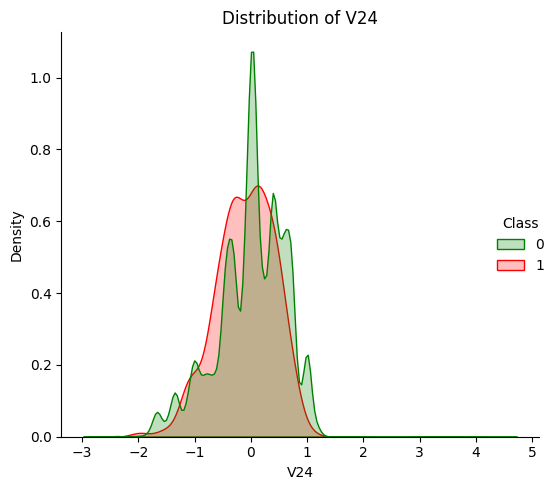

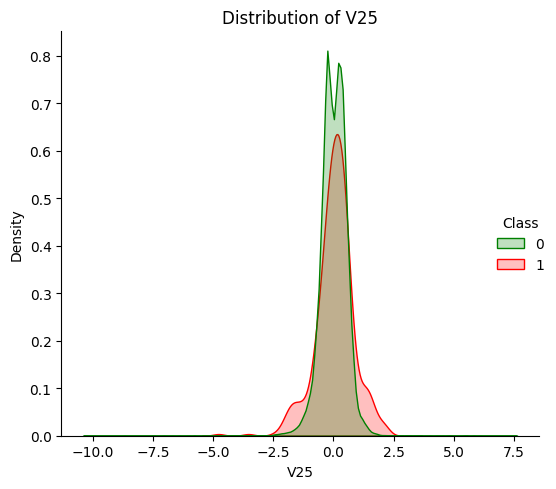

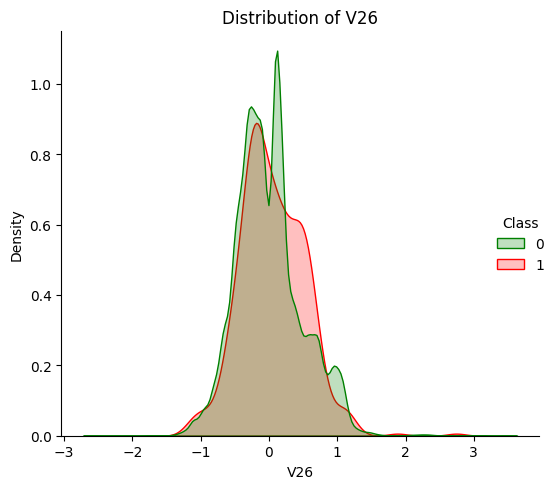

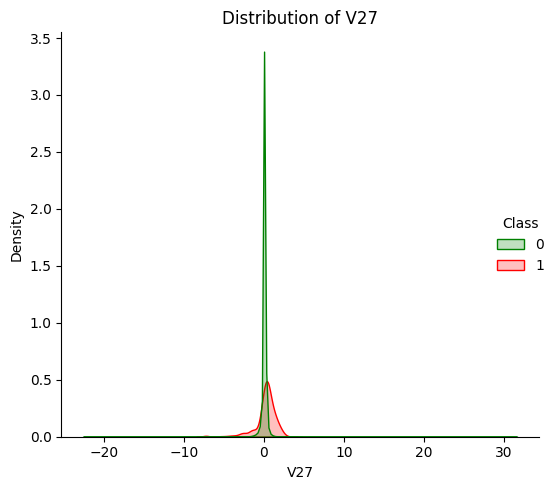

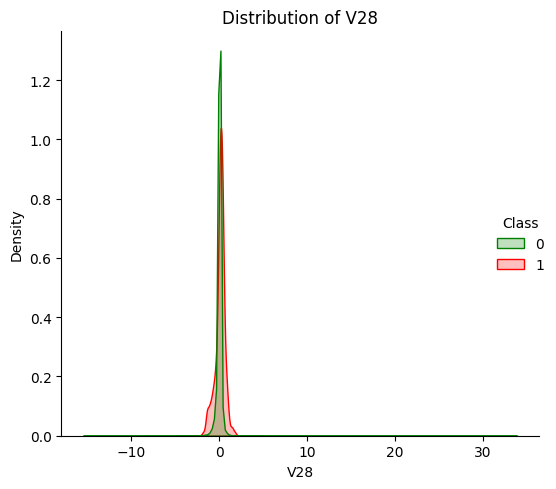

In [139]:
#Look at each V's distribution
columns = cc.iloc[:, 1:29].columns  # Select the V1 to V28 columns

frauds = cc['Class'] == 1
nomral = cc['Class'] == 0

for col in columns:
    sns.displot(
        data=cc,
        x=col,
        hue="Class",
        kind="kde",
        palette={0: "g", 1: "r"}, 
        fill=True,
        common_norm=False
    )
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()


### Reasoning behind choice behind featured selection ###

It can be seen that V2, V3, V4, V9, V10, V11, V12, V14, V16, V17, V18, V19, V27, are the variables that exhibit interesting behaviour in which the difference between the fraud dataset and legitamite datasets are different. This is done after testing with all variables. 

This approach is better because of 
- Featured Selection: selects only the most relevant features, reducing noise and reducing dimensionality of the dataset
- Reduced Overfitting: could introduce noise, resulting in overfitting. Reducing overfitting could help to improve the generalizatility of the model
- Help to improve model interpretability: can help to understand model's decisions for what is fraud and what is not-fraud / legitamite, making the model more interpretable

Here, we compress the range of amounts (transaction amounts) to prevent skewing the model to bias towards transactions amounts

In [141]:
## Compress range of amounts to prevent skewing
cc['compressed_amount'] = np.log(cc.Amount + 0.001)
cc = cc.drop(['Amount'], axis=1)
cc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,compressed_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


### ML Model ###

In [143]:
## For all independant Variables
## Drop all not V2, V3, V4, V9, V10, V11, V12, V14, V16, V17, V18, V19, V27,
x = cc.drop(["Class", "V1", "V5", "V6", "V7", "V8", "V13", "V15", "V20", "V21", "V22", "V23", "V24", "V25", "V26"], axis = 1).values

## For dependant variable
y = cc["Class"].values

***Seperate the Dataset into training sets and testing sets***

In [144]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 2, test_size = 0.20)

As seen before, there is an imbalance legitamite vs fraud cases. Meaning that there are more legimate cases than fraud, which is a class imbalanced dataset which could lead to the model forming a bias for the majority class, in this case the legitmate transactions. 

We will utilize SMOTE to resample the dataset, basically make duplicate fraud cases so that the number of fraud cases that the model is trained on, and the number of legitamite cases the model is trained on is the same.

In [145]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42) 
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

## show difference before and after SMOTE
print(f"Dataset before SMOTE ~ Fraud: {len(y_train[y_train == 1])} Legitamite: {len(y_train[y_train == 0])}")

print(f"Dataset before SMOTE ~ Fraud: {len(y_train_smote[y_train_smote == 1])} Legitamite: {len(y_train_smote[y_train_smote == 0])}")

Dataset before SMOTE ~ Fraud: 408 Legitamite: 227437
Dataset before SMOTE ~ Fraud: 227437 Legitamite: 227437


#### Initial Training of the Model, and evaluating the performance of the model

In [220]:
from sklearn.ensemble import RandomForestClassifier
trees = 10
rf1 = RandomForestClassifier(n_estimators = trees, random_state = 42, class_weight='balanced', max_features = 2)

## Train
rf1.fit(x_train_smote, y_train_smote)

RandomForestClassifier(class_weight='balanced', max_features=2, n_estimators=10,
                       random_state=42)

In [221]:
prediction_rf = rf1.predict(x_test)

In [222]:
## Evaluation
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.metrics import balanced_accuracy_score
print("SMOTE + RandomForest classification")
print("balanced-accuracy: {}".format(balanced_accuracy_score(y_test, prediction_rf)))
print("accuracy: {}".format(accuracy_score(y_test, prediction_rf)))
print("precision: {}".format(precision_score(y_test, prediction_rf)))
print("recall: {}".format(recall_score(y_test, prediction_rf)))
print("f2: {}".format(fbeta_score(y_test, prediction_rf, beta=2)))


SMOTE + RandomForest classification
balanced-accuracy: 0.9284307766497717
accuracy: 0.9995084442259752
precision: 0.8181818181818182
recall: 0.8571428571428571
f2: 0.8490566037735849


From above, it can be seen that the model performed pretty well, 92.25% balanced accuracy, with a precision of 86.58%, which measures the the accuracy rate of predicting fraud cases. Basically, 86.58% of cases predicted as fraud cases were actually fraud cases. We can reduce this by utilizing GridSearchCV to optimize the hyperparameters

### Optimized HyperParameters

In [226]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, make_scorer, classification_report, confusion_matrix

precision_scorer = make_scorer(precision_score)

#params of the model
param_grid = {"max_depth": [3,5, None],
              "n_estimators":[10, 50, 100, 150],
              "max_features": [1, 2, 4, 5, 6]}

model = RandomForestClassifier(max_features=3, max_depth=2 ,n_estimators=10, random_state=3, criterion='entropy', n_jobs=1, verbose=1)
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring= 'precision')
grid_search.fit(x_train_smote, y_train_smote)  

print(grid_search.best_score_)
print(grid_search.best_params_)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

0.999723074408245
{'max_depth': None, 'max_features': 1, 'n_estimators': 150}


The best parameters were n_estimators = 100, max_depth = None, max_features = 4 : 
We are now going to train a model with these optimized hyperparameters to see how it performed

### Optimized Model

In [215]:
from sklearn.ensemble import RandomForestClassifier
rf_optimal = RandomForestClassifier(n_estimators = 100, max_depth = None, max_features = 4)

## Train
rf_optimal.fit(x_train_smote, y_train_smote)

RandomForestClassifier(max_features=4)

In [216]:
## Evaluation
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score
y_pred = rf_optimal.predict(x_test)
print("SMOTE + RandomForest classification")
print("balanced-accuracy: {}".format(balanced_accuracy_score(y_test, y_pred)))
print("accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("precision: {}".format(precision_score(y_test, y_pred)))
print("recall: {}".format(recall_score(y_test, y_pred)))
print("f2: {}".format(fbeta_score(y_test, y_pred, beta=2)))


SMOTE + RandomForest classification
balanced-accuracy: 0.9344446928178776
accuracy: 0.9996488887328394
precision: 0.8902439024390244
recall: 0.8690476190476191
f2: 0.8732057416267942


### Further Evaluation

/var/folders/59/dbnn7k_n491_rj581dqf3j1h0000gn/T/ipykernel_7837/2936097328.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90);


NameError: name 'aw' is not defined

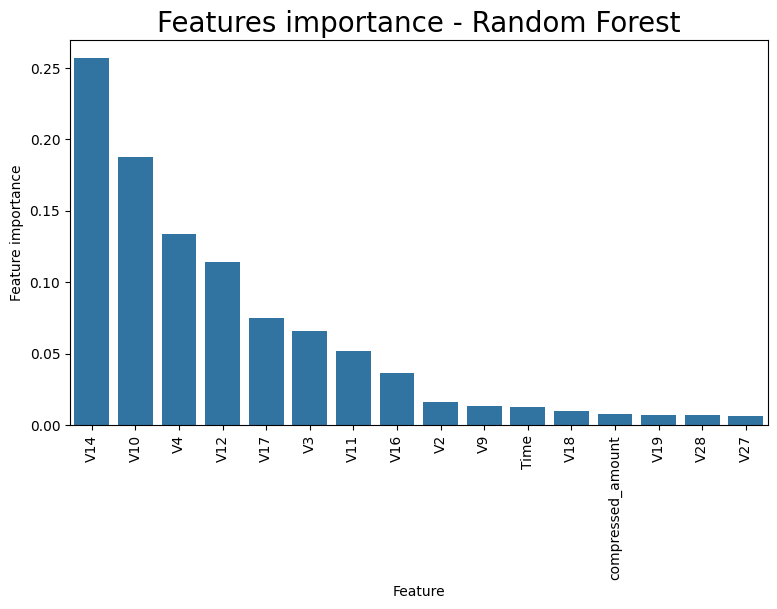

In [227]:
features = ["Time", "V2", "V3","V4","V9","V10","V11","V12","V14","V16","V17","V18","V19", "V27", "V28", "compressed_amount"]
# V2, V3, V4, V9, V10, V11, V12, V14, V16, V17, V18, V19, V27,
plt.figure(figsize = (9,5))

feature_importance = pd.DataFrame({'Feature': features, 'Feature importance': rf_optimal.feature_importances_});
feature_importance = feature_importance.sort_values(by='Feature importance',ascending=False)
g = sns.barplot(x='Feature',y='Feature importance',data=feature_importance);
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_title('Features importance - Random Forest',fontsize=20);aw
plt.show() 